# Task A of our creative extension

Our task A consists in two main goals:
1. Compare the predictive performances of the different _outcome variables_ specified in Tables 4 and 6 of the paper to predict whether a household is from the treatment of control group.

To achieve this, we first build a baseline model that only includes control variables, i.e. features from the 2000 census, and features from the 2005 survey that are used either in their regression model 3 or as robustness checks in Table 7 of the paper. 
50 such features were selected.
The task consists in predicting whether an household is from the treatment or control group based on these features. The target feature is therefore the _intention-to-treat_ feature, referred as `dpisofirme` throughout the code.

Our expectation is that the baseline model should not perform well because the authors provided ample evidences that treatment and control households are well balanced over these control variables. As we will see, our models could actually exploit .. and perform very well on this baseline case.

Then we construct a model for each _outcome variable_, which includes the outcome variable besides the control variables. 
In the paper, the intention-to-treat variable is shown to be important to predict the outcome variables, hence we expect that including them in the model improves our predictions of the intention-to-treat variable. 
As you will see, we could not observe such an effect because the baseline predictions were already perfect.

2. Compare the feature importances of the _outcome variables_ with the regression coefficients from the paper

To achieve this, we perform a feature importance analysis on the models explained above and obtain an importance score for each outcome variable.
Then we compare first qualitatively the importance ranking of the outcome variables using our importance scores with the one using the paper's regression coefficients.
It turns out that they agree relatively well.
We then compare them quantitatively and it turns out that they agree pretty well too.

Reference to the [paper](https://www.aeaweb.org/articles?id=10.1257/pol.1.1.75):

Matias D. Cattaneo, Sebastian Galiani, Paul J. Gertler, Sebastian Martinez, and Rocio Titiunik. Housing, health, and happiness. American Economic Journal: Economic Policy, 1(1):75–105, February 2009.

Outline of the notebook:

- [Import libraries](#Import-libraries)
- [Load the dataset](#Load-the-dataset)
- [Preprocessing of the dataset](#Preprocessing-of-the-dataset)
- [Select features](#Select-features)
- [Split into train and test sets](#Split-into-train-and-test-sets)
- [Assess the missingness in train and test sets](#Assess-the-missingness-in-train-and-test-sets)
- [Preprocessing of the features](#Preprocessing-of-the-features)
- [Construct and fit the classifiers](#Construct-and-fit-the-classifiers)
- [Comparison of the predictive performances](#Comparison-of-the-predictive-performances)
- [Comparison of our feature importances with their _intention-to-treatment_ coefficients](#Comparison-of-our-feature-importances-with-their-intention-to-treatment-coefficients)

## Import libraries

Let's start by importing the usual good stuff. 
The only custom import is the module `variables`, which contains the names of the necessary variables for each part of the notebook. 
Importing them in this way avoids cluttering the notebook's cells.

In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 41)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = os.path.join('..', 'data')
FIGURES_PATH = os.path.join('..', 'figures')
SCRIPTS_PATH = os.path.join('..', 'src')

# Enable access to modules in scripts directory
sys.path.append(os.path.abspath(SCRIPTS_PATH))

# `variables` contains the necessary variables to use for each table
import variables

## Load the dataset

In [3]:
hh_df = pd.read_stata(os.path.join(DATA_PATH, 'PisoFirme_AEJPol-20070024_household.dta'))

The `hh_df` dataset contains information at the households level. It contains 2783 households and 78 features:

In [4]:
print(hh_df.shape)
hh_df.head()

(2783, 78)


,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,C_people,C_rooms,C_HHpersons,C_waterland,C_waterhouse,C_waterbath,C_gasheater,C_refrigerator,C_washing,C_telephone,...,S_dem8,S_seguropopular,S_shcementfloor,S_cementfloorkit,S_cementfloordin,S_cementfloorbat,S_cementfloorbed,S_satisfloor,S_satishouse,S_satislife,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.002443,0.151522,0.272279,0.004885,0.114775,0.247868,0.524304,...,0.0,0.0,0.6,1.0,0.0,1.0,0.0,1.0,1.0,1.0,14.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487
1,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.002443,0.151522,0.272279,0.004885,0.114775,0.247868,0.524304,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,17.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.615806
2,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.002443,0.151522,0.272279,0.004885,0.114775,0.247868,0.524304,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778
3,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.002443,0.151522,0.272279,0.004885,0.114775,0.247868,0.524304,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,11.385092,11.918390
4,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.002443,0.151522,0.272279,0.004885,0.114775,0.247868,0.524304,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.703783,10.819778


## Preprocessing of the dataset

As always, we start by preprocessing the datasets.
Here we proceed as the authors specify at the top of page 82. 
More precisely, we remove the households with missing geographical information.

The households' dataset contains initially 1393 and 1390 households from the control and treatment groups respectively:

In [7]:
(hh_df['dpisofirme'] == 0).sum(), (hh_df['dpisofirme'] == 1).sum()

(1393, 1390)

Let's remove the households with missing geographical location information as indicated by the authors:

In [8]:
hh_df.dropna(subset=['idcluster'], inplace=True)

In [9]:
(hh_df['dpisofirme'] == 0).sum(), (hh_df['dpisofirme'] == 1).sum()

(1393, 1362)

We are left with 1393 and 1362 households from the control and treatment groups.

## Select features

In [10]:
control_variables = variables.control_variables
table_4_outcomes = variables.table_4_outcomes
table_6_outcomes = variables.table_6_outcomes

In [11]:
outcome_variables = table_4_outcomes + table_6_outcomes

In [12]:
df = hh_df.loc[:, control_variables + outcome_variables + ['dpisofirme']].copy()

In [13]:
df

,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,C_people,C_rooms,C_HHpersons,C_waterbath,C_gasheater,C_refrigerator,C_washing,C_telephone,C_vehicle,...,S_electricity,S_hasanimals,S_animalsinside,S_garbage,S_washhands,S_cashtransfers,S_milkprogram,S_foodprogram,S_seguropopular,S_shcementfloor,S_cementfloorkit,S_cementfloordin,S_cementfloorbat,S_cementfloorbed,S_satisfloor,S_satishouse,S_satislife,S_cesds,S_pss,dpisofirme
0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487,0.300000,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.272279,0.004885,0.114775,0.247868,0.524304,0.644129,...,1,1.0,0.0,1.0,3.0,0.00,0.0,0.0,0.0,0.6,1.0,0.0,1.0,0.0,1.0,1.0,1.0,14.0,12.0,0.0
1,0.0,0.0,0.0,0.0,0.0,5.298317,9.615806,0.300000,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.272279,0.004885,0.114775,0.247868,0.524304,0.644129,...,1,0.0,0.0,1.0,3.0,0.00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,17.0,24.0,0.0
2,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778,0.300000,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.272279,0.004885,0.114775,0.247868,0.524304,0.644129,...,1,0.0,0.0,1.0,5.0,0.00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,16.0,0.0
3,0.0,0.0,0.0,0.0,0.0,11.385092,11.918390,0.300000,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.272279,0.004885,0.114775,0.247868,0.524304,0.644129,...,1,0.0,0.0,1.0,4.0,0.00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.0,19.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.703783,10.819778,0.300000,0.036629,0.555554,819.0,3530.0,3.097682,4.310134,0.272279,0.004885,0.114775,0.247868,0.524304,0.644129,...,1,1.0,0.0,1.0,2.0,0.00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,0.0,0.0,1.0,0.0,1.0,5.298317,9.615806,0.538462,0.100774,0.759924,454.0,1866.0,3.264429,4.110127,0.333881,0.022024,0.113730,0.286599,0.660113,0.534601,...,1,0.0,0.0,1.0,1.0,0.00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,19.0,20.0,1.0
2751,0.0,0.0,0.0,0.0,0.0,5.991465,10.819778,0.538462,0.100774,0.759924,454.0,1866.0,3.264429,4.110127,0.333881,0.022024,0.113730,0.286599,0.660113,0.534601,...,1,0.0,0.0,1.0,7.0,0.00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,11.0,1.0
2752,0.0,0.0,0.0,0.0,0.0,5.991465,9.210340,0.538462,0.100774,0.759924,454.0,1866.0,3.264429,4.110127,0.333881,0.022024,0.113730,0.286599,0.660113,0.534601,...,1,1.0,0.0,1.0,8.0,0.00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,19.0,1.0
2753,0.0,0.0,0.0,0.0,0.0,6.396930,11.918390,0.538462,0.100774,0.759924,454.0,1866.0,3.264429,4.110127,0.333881,0.022024,0.113730,0.286599,0.660113,0.534601,...,1,1.0,0.0,1.0,7.0,0.00,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,10.0,1.0


In [14]:
binary_variables = [col for col in df.columns[df.nunique() == 2] if col != 'dpisofirme']
numeric_variables = list(df.columns[df.nunique() > 2])
print(f"There are {len(binary_variables)} binary features and "
      f"{len(numeric_variables)} numeric features in total.")

There are 21 binary features and 39 numeric features in total.


## Split into train and test sets

We first split our dataset into a train set containing 80% of the data and a test set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df[control_variables + outcome_variables], df['dpisofirme'], 
                                                    train_size=0.8, random_state=2020)

## Assess the missingness in train and test sets

In [16]:
def missingness_summary_for_df(df):
    return pd.concat([df.isna().sum(), df.isna().mean()], axis=1).rename(
        columns={0: 'missingness_count', 1: 'missingness_fraction'})

Let's look at the missingness of the numeric variables:

In [17]:
missingness_summary_for_df(X_train[numeric_variables]).join(missingness_summary_for_df(X_test[numeric_variables]), 
                                                            lsuffix='_train', rsuffix='_test')

,missingness_count_train,missingness_fraction_train,missingness_count_test,missingness_fraction_test
S_logrent,148,0.067151,38,0.068966
S_logsell,229,0.103902,64,0.116152
C_blocksdirtfloor,140,0.063521,35,0.063521
C_HHdirtfloor,140,0.063521,35,0.063521
C_child05,140,0.063521,35,0.063521
C_households,140,0.063521,35,0.063521
C_people,140,0.063521,35,0.063521
C_rooms,140,0.063521,35,0.063521
C_HHpersons,140,0.063521,35,0.063521
C_waterbath,140,0.063521,35,0.063521


Many features have missing values, but they are never in too large proportion (largest number of missing data is for `S_spouseeduc` and concerns about 12% of the records).

Let's also look at the missingness for binary variables:

In [18]:
missingness_summary_for_df(X_train[binary_variables]).join(missingness_summary_for_df(X_test[binary_variables]), 
                                                            lsuffix='_train', rsuffix='_test')

,missingness_count_train,missingness_fraction_train,missingness_count_test,missingness_fraction_test
S_instsanita,3,0.001361,0,0.0
S_restsanita,2,0.000907,0,0.0
S_constceili,2,0.000907,0,0.0
S_restowalls,1,0.000454,0,0.0
S_improveany,0,0.000000,0,0.0
S_waterland,0,0.000000,0,0.0
S_waterhouse,0,0.000000,0,0.0
S_electricity,0,0.000000,0,0.0
S_hasanimals,0,0.000000,0,0.0
S_animalsinside,0,0.000000,0,0.0


There is almost nothing missing, good news!

## Preprocessing of the features

Our preprocessing consists in the following steps:

1. Standardize the numeric features of the train and test sets using the mean and standard deviation of the train set
2. Replace all missing values with value 0.
3. One-hot-encode the binary features

In [19]:
def one_hot_encode(X_train, X_test):
    """One-hot-encode the columns of X_train and X_test w.r.t. means and stds from X_train. """
    if ~(X_train.columns == X_test.columns).all():
        raise ValueError("X_train and X_test should have the columns in the same order.")
    colnames = X_train.columns
    ohe = OneHotEncoder(sparse=False, drop='first')
    # One-hot-encode train and test sets (it produces numpy arrays)
    X_train_ohe = ohe.fit_transform(X_train)
    X_test_ohe = ohe.transform(X_test)

    # Add column names back to resulting numpy arrays
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=colnames)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=colnames)
    return X_train_ohe, X_test_ohe

In [20]:
def standardize(X_train, X_test):
    """Standardize the columns of X_train and X_test w.r.t. means and stds from X_train. """
    if ~(X_train.columns == X_test.columns).all():
        raise ValueError("X_train and X_test should have the columns in the same order.")
    colnames = X_train.columns
    sc = StandardScaler()
    # Standardize train and test sets (it produces numpy arrays)
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)

    # Add column names back to resulting numpy arrays
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=colnames)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=colnames)
    return X_train_scaled, X_test_scaled

### Numeric features

We standardize the numeric variables in the train set and keep the means and standard deviations to apply the same transformations to the test set.

In [21]:
X_train_numeric_scaled, X_test_numeric_scaled = standardize(X_train[numeric_variables], X_test[numeric_variables])

We impute the missing values with 0, which means that we set them equal to the mean value.

In [22]:
X_train_numeric_scaled_imputed = X_train_numeric_scaled.fillna(value=0.)
X_test_numeric_scaled_imputed = X_test_numeric_scaled.fillna(value=0.)

Let's check whether we imputed them successfully:

In [23]:
X_train_numeric_scaled_imputed.isna().any().any() or X_test_numeric_scaled_imputed.isna().any().any()

False

Yes, we did!

### Binary features

For binary features, we need to impute the missing values first, before being able to one-hot-encode the values. 
So let's impute the missing values with the value 0, which is the generic method used by the paper's authors.

In [24]:
X_train_binary_imputed = X_train[binary_variables].fillna(value=0)
X_test_binary_imputed = X_test[binary_variables].fillna(value=0)

Let's check whether we imputed them successfully:

In [25]:
X_train_binary_imputed.isna().any().any() or X_test_binary_imputed.isna().any().any()

False

Yes, we did!
We can now one-hot-encode the binary variables in the train and test sets.

In [26]:
X_train_binary_ohe, X_test_binary_ohe = one_hot_encode(X_train_binary_imputed, 
                                                          X_test_binary_imputed)

### Assemble the preprocessed train and test sets

In [27]:
X_train_preprocessed = X_train_numeric_scaled_imputed.join(X_train_binary_ohe)
X_test_preprocessed = X_test_numeric_scaled_imputed.join(X_test_binary_ohe)

## Construct and fit the classifiers

We construct 3 different classifiers for each model.
The 3 classifiers are the following:
1. Logistic regression
2. Random forest
3. XGBoost

We use grid-search cross-validation to select the best hyperparameters of each classifier for each model.

In [28]:
# Define hyper-parameters to optimize using cross-validation
lr_hyperparams_dict = {'C': [0.01, 0.1, 1.0, 10, 100.]}
rfc_hyperparams_dict = {'n_estimators': [50, 100, 200], 'max_depth': [None, 2, 10, 20]}
xgbc_hyperparams_dict = {'reg_lambda': [0.1, 1., 10.], 'learning_rate': [0.1, 0.3, 0.8]}

fitted_models_running_list = []
results_running_list = []

for feature_of_interest in [None] + outcome_variables:
    print(f"Feature: {feature_of_interest}")
    if feature_of_interest is None:
        selected_features = control_variables
        feature_of_interest_string = 'baseline'
        importance_score = None
    else:
        selected_features = [feature_of_interest] + control_variables
        feature_of_interest_string = feature_of_interest

    # Logistic regression
    lr = LogisticRegression(random_state=2020, max_iter=1000)
    lr_cv = GridSearchCV(lr, lr_hyperparams_dict)
    start = time.time()
    lr_cv.fit(X_train_preprocessed[selected_features], y_train)
    print(f"Logistic regression CV computed in {time.time() - start:.0f} seconds.")
    y_test_pred = lr_cv.predict(X_test_preprocessed[selected_features])

    # Compute feature importance
    lr_feature_importance_series = pd.Series(data=np.squeeze(lr_cv.best_estimator_.coef_), index=selected_features).sort_values()
    if feature_of_interest is not None:
        importance_score = lr_feature_importance_series[feature_of_interest]

    # Save results
    results_running_list.append({
        'variable': feature_of_interest_string,
        'model': 'logistic_regression',
        'f1':  metrics.f1_score(y_test, y_test_pred),
        'accuracy':  metrics.accuracy_score(y_test, y_test_pred),
        'importance_score': importance_score
    })

    # Random forest classifier
    rfc = RandomForestClassifier(random_state=2020)
    rfc_cv = GridSearchCV(rfc, rfc_hyperparams_dict)
    start = time.time()
    rfc_cv.fit(X_train_preprocessed[selected_features], y_train)
    print(f"Random forest CV computed in {time.time() - start:.0f} seconds.")
    y_test_pred = rfc_cv.predict(X_test_preprocessed[selected_features])

    # Compute feature importance
    rfc_feature_importance_series = pd.Series(data=rfc_cv.best_estimator_.feature_importances_, index=selected_features).sort_values()
    if feature_of_interest is not None:
        importance_score = rfc_feature_importance_series[feature_of_interest]

    # Save results
    results_running_list.append({
        'variable': feature_of_interest_string,
        'model': 'random_forest',
        'f1':  metrics.f1_score(y_test, y_test_pred),
        'accuracy':  metrics.accuracy_score(y_test, y_test_pred),
        'importance_score': importance_score
    })

    # XGBoost classifier
    xgbc = XGBClassifier(random_state=2020)
    xgbc_cv = GridSearchCV(xgbc, xgbc_hyperparams_dict)
    start = time.time()
    xgbc_cv.fit(X_train_preprocessed[selected_features], y_train)
    print(f"XGBoost CV computed in {time.time() - start:.0f} seconds.")
    y_test_pred = xgbc_cv.predict(X_test_preprocessed[selected_features])

    # Compute feature importance
    xgbc_feature_importance_series = pd.Series(data=xgbc_cv.best_estimator_.feature_importances_, index=selected_features).sort_values()
    if feature_of_interest is not None:
        importance_score = xgbc_feature_importance_series[feature_of_interest]

    # Save results
    results_running_list.append({
        'variable': feature_of_interest_string,
        'model': 'xgboost',
        'f1':  metrics.f1_score(y_test, y_test_pred),
        'accuracy':  metrics.accuracy_score(y_test, y_test_pred),
        'importance_score': importance_score
    })

    # Save models and feature importances
    fitted_models_running_list.append({
        'variable': feature_of_interest_string,
        'logistic_regression': (lr_cv, lr_feature_importance_series),
        'random_forest': (rfc_cv, rfc_feature_importance_series),
        'xgboost': (xgbc_cv, xgbc_feature_importance_series),
    })

# Construct dataframes with classifiers results
results_cv_df = pd.DataFrame.from_dict(results_running_list)
results_readable_cv_df = results_cv_df.pivot_table(values=['f1', 'accuracy', 'importance_score'], index='variable', columns='model')
importances_cv_df = pd.DataFrame.from_dict(fitted_models_running_list).set_index('variable')

Feature: None
Logistic regression CV computed in 2 seconds.
Random forest CV computed in 28 seconds.
XGBoost CV computed in 12 seconds.
Feature: S_shcementfloor
Logistic regression CV computed in 2 seconds.
Random forest CV computed in 26 seconds.
XGBoost CV computed in 12 seconds.
Feature: S_cementfloorkit
Logistic regression CV computed in 2 seconds.
Random forest CV computed in 28 seconds.
XGBoost CV computed in 13 seconds.
Feature: S_cementfloordin
Logistic regression CV computed in 3 seconds.
Random forest CV computed in 25 seconds.
XGBoost CV computed in 12 seconds.
Feature: S_cementfloorbat
Logistic regression CV computed in 3 seconds.
Random forest CV computed in 26 seconds.
XGBoost CV computed in 12 seconds.
Feature: S_cementfloorbed
Logistic regression CV computed in 2 seconds.
Random forest CV computed in 26 seconds.
XGBoost CV computed in 13 seconds.
Feature: S_satisfloor
Logistic regression CV computed in 2 seconds.
Random forest CV computed in 26 seconds.
XGBoost CV compu

## Comparison of the predictive performances

**Table caption**:

Prediction performances on the test set.
The left-most column represents the feature that is included as covariate, besides the control variables. 
The _baseline_ variable means that only the control variables are included.
Columns 2 to 4 show the accuracy of each classifier.
Columns 5 to 7 show the F1-score of each classifier.
The 3 right-most columns represent the feature importance associated to the feature mentioned in the first column for each classifier.

In [29]:
results_readable_cv_df

accuracy                          \
model            logistic_regression random_forest   xgboost   
variable                                                       
S_cementfloorbat            0.816697      0.998185  0.996370   
S_cementfloorbed            0.807623      1.000000  0.996370   
S_cementfloordin            0.822142      1.000000  0.996370   
S_cementfloorkit            0.833031      0.998185  0.996370   
S_cesds                     0.827586      0.998185  0.998185   
S_pss                       0.822142      0.998185  1.000000   
S_satisfloor                0.831216      0.998185  1.000000   
S_satishouse                0.814882      0.998185  1.000000   
S_satislife                 0.822142      0.998185  1.000000   
S_shcementfloor             0.820327      0.998185  0.998185   
baseline                    0.818512      1.000000  1.000000   

                                  f1                          \
model            logistic_regression random_forest   xgboost   
variable                                                       
S_cementfloorbat            0.818018      0.998205  0.996403   
S_cementfloorbed            0.811388      1.000000  0.996403   
S_cementfloordin            0.824373      1.000000  0.996403   
S_cementfloorkit            0.836299      0.998205  0.996403   
S_cesds                     0.828829      0.998205  0.998205   
S_pss                       0.821168      0.998205  1.000000   
S_satisfloor                0.831216      0.998205  1.000000   
S_satishouse                0.814545      0.998205  1.000000   
S_satislife                 0.822464      0.998205  1.000000   
S_shcementfloor             0.825397      0.998205  0.998205   
baseline                    0.817518      1.000000  1.000000   

                    importance_score                          
model            logistic_regression random_forest   xgboost  
variable                                                      
S_cementfloorbat            1.054737      0.000635  0.001446  
S_cementfloorbed            1.919509      0.022780  0.026096  
S_cementfloordin            1.824539      0.011971  0.010832  
S_cementfloorkit            1.930146      0.029646  0.127061  
S_cesds                    -0.350066      0.002144  0.001157  
S_pss                      -0.320535      0.001627  0.000986  
S_satisfloor                1.017132      0.002880  0.000338  
S_satishouse                0.394932      0.000276  0.000000  
S_satislife                 0.624830      0.000305  0.000470  
S_shcementfloor             1.056183      0.042970  0.094014  
baseline                         NaN           NaN       NaN

In [30]:
y_test_chance_accuracy = y_test.value_counts(normalize=True).values.max()
print(f"Chance accuracy on the test set is {y_test_chance_accuracy:.4f}.")

Chance accuracy on the test set is 0.5064.


Impressively, the baseline models, i.e. the models that only uses the control variables, achieve perfect prediction accuracy and F1-score on the test set using the random forest and XGBoost classifiers.

We did not expect this since the authors provide evidence that households selected in the treatment and control groups are similar in all control variables.

We notice that the results of logistic regressions are not bad as well (all models have an accuracy above 0.8) considering that chance accuracy is 0.51.
The fact that the logistic regression classifier still performs poorly compared to the random forest and XGBoost classifiers suggests that the relationship between the variables and the treatment/control target is substantially non-linear.

Let's look at the distribution of the features that are considered the most important according to our classifiers.

In [31]:
def get_k_most_important_features(importances_cv_df, k=5):
    """Return a dataframe with the k most important features for each classifer, 
    and the list containing these features."""
    # Get the feature importance series for each classifier
    lr_baseline_imp_series = importances_cv_df.loc['baseline', 'logistic_regression'][1]
    rfc_baseline_imp_series = importances_cv_df.loc['baseline', 'random_forest'][1]
    xgbc_baseline_imp_series = importances_cv_df.loc['baseline', 'xgboost'][1]

    # Select k most important features
    lr_most_important_features = list(lr_baseline_imp_series.abs().sort_values()[-k:].index)
    rfc_most_important_features = list(rfc_baseline_imp_series.abs().sort_values()[-k:].index)
    xgbc_most_important_features = list(xgbc_baseline_imp_series.abs().sort_values()[-k:].index)

    # Build a table with most important features of the 3 classifiers
    # Logistic regression dataframe
    lr_df = (pd.DataFrame(lr_baseline_imp_series[lr_most_important_features].sort_values(ascending=False))
               .reset_index().rename(columns={'index': 'feature', 0: 'feature_importance'}))
    lr_df['model'] = 'logistic_regression'
    # Order the columns in a easier-to-read way
    lr_df = lr_df[['model', 'feature', 'feature_importance']]

    # Random forest dataframe
    rfc_df = (pd.DataFrame(rfc_baseline_imp_series[rfc_most_important_features].sort_values(ascending=False))
               .reset_index().rename(columns={'index': 'feature', 0: 'feature_importance'}))
    rfc_df['model'] = 'random_forest'
    # Order the columns in a easier-to-read way
    rfc_df = rfc_df[['model', 'feature', 'feature_importance']]

    # XGBoost dataframe
    xgbc_df = (pd.DataFrame(xgbc_baseline_imp_series[xgbc_most_important_features].sort_values(ascending=False))
               .reset_index().rename(columns={'index': 'feature', 0: 'feature_importance'}))
    xgbc_df['model'] = 'xgboost'
    # Order the columns in a easier-to-read way
    xgbc_df = xgbc_df[['model', 'feature', 'feature_importance']]

    most_important_features_df = pd.concat([lr_df, rfc_df, xgbc_df], axis=1)

    most_important_features_list = list(set.union(set(lr_df['feature'].values), 
                                     set(rfc_df['feature'].values),
                                     set(xgbc_df['feature'].values)))

    return most_important_features_df, most_important_features_list

In [32]:
most_important_features_df, most_important_features_list = get_k_most_important_features(importances_cv_df, k=5)

Here are the features ranked as most important for each classifier:

In [33]:
most_important_features_df

,model,feature,feature_importance,model,feature,feature_importance,model,feature,feature_importance
0,logistic_regression,C_people,11.145004,random_forest,C_blocksdirtfloor,0.068607,xgboost,C_poverty,0.121230
1,logistic_regression,C_earnincome,4.516010,random_forest,C_waterbath,0.065149,xgboost,C_waterbath,0.099002
2,logistic_regression,C_washing,4.439839,random_forest,C_refrigerator,0.062296,xgboost,C_overcrowding,0.097288
3,logistic_regression,C_HHpersons,-3.932449,random_forest,C_households,0.059715,xgboost,C_blocksdirtfloor,0.088649
4,logistic_regression,C_households,-9.761817,random_forest,C_washing,0.058636,xgboost,C_dropouts515,0.081610


We note that several features are considered important by several classifiers, such as `C_households`, `C_blocksdirtfloor`, `C_waterbath`.

Note that the feature importance scores from the logistic regression are calculated differently from the ones of the random forest and XGBoost classifiers and their values cannot be compared. We only look at the relative rankings of the features here.

Let's look at the distribution of all the most important features reported in the above table.

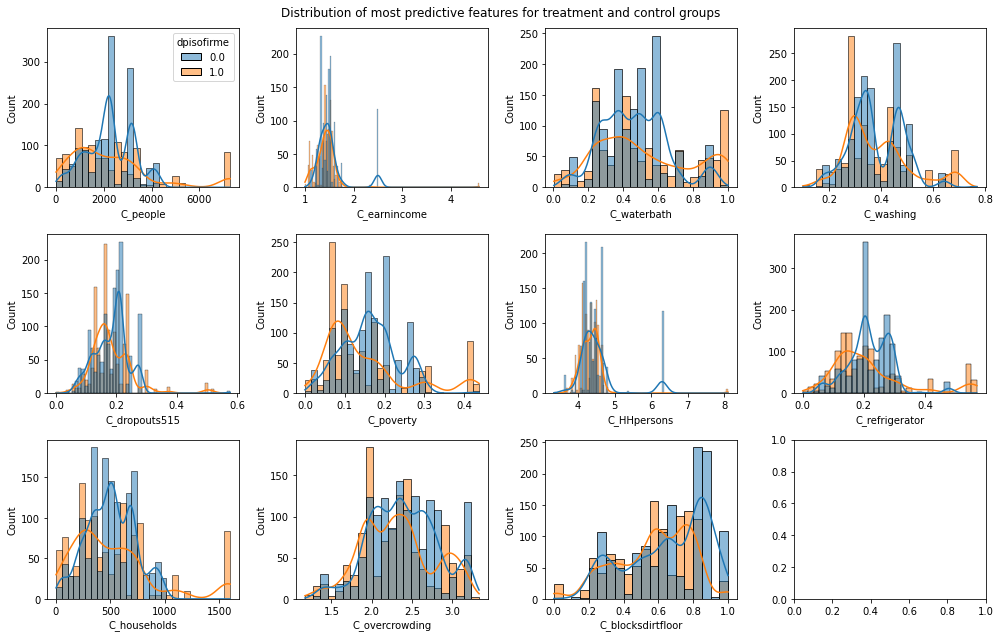

In [34]:
fig, axes = plt.subplots(3, 4, figsize=(14, 9))
fig.suptitle("Distribution of most predictive features for treatment and control groups")

for i, (feature, ax) in enumerate(zip(most_important_features_list, axes.ravel())):
    if i == 0:
        show_legend = True
    else: 
        show_legend = False
    sns.histplot(data=df, x=feature, kde=True, hue='dpisofirme', ax=ax, legend=show_legend)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'distribution_of_most_important_features_task_A.png'))

We see that the distribution for the treatment and control groups are indeed relatively different for these features.
It is remarkable that our classifiers are able to take advantage of this to such an extent as to perfectly predict the treatment/control labels on a held-out test set.

## Comparison of our feature importances with their _intention-to-treatment_ coefficients

We now compare the feature importances of the outcome variables obtained in the present task, with the coefficients of the _intention-to-treat_ variable that the authors obtain in their regression analyses.

We expect that our feature importances should loosely agree with their coefficients, meaning that the extent to which the _intention-to-treat_ variable is linearly related to a variable is proportional to the importance of this variable to predict the _intention-to-treat_ variable.

We will use the feature importances from the logistic regression because they range over positive as well as negative values, contrarily to the feature importance scores from random forest and XGBoost classifiers.

In [35]:
lr_outcome_importances_series = results_readable_cv_df.loc[:, ('importance_score', 'logistic_regression')].rename('lr_importance_score')

The following cell contains the results reported in Tables 4 and 6 of the paper.

In [36]:
paper_importances_series = pd.Series({
    'S_cementfloorbat': 0.105,
    'S_cementfloorbed': 0.238,
    'S_cementfloordin': 0.21,
    'S_cementfloorkit': 0.255,
    'S_cesds': -2.315,
    'S_pss': -1.751,
    'S_satisfloor': 0.219,
    'S_satishouse': 0.092,
    'S_satislife': 0.112,
    'S_shcementfloor': 0.202,
}).rename('paper_importance_score')

**Table caption:**

Features rankings.
The left-most column shows the features ranked by their paper's coefficients. The second column shows the value of the coefficient.
The two right-most columns show the features ranked by their feature importance scores that we computed above, and the value of the scores.

In [37]:
paper_and_lr_rankings_df = pd.concat([pd.DataFrame(paper_importances_series.sort_values()).reset_index()
                                      .rename(columns={'index': 'paper_ranking'}),
                                      pd.DataFrame(lr_outcome_importances_series.sort_values()).reset_index()
                                      .rename(columns={'variable': 'lr_ranking'})], axis=1) 
paper_and_lr_rankings_df

,paper_ranking,paper_importance_score,lr_ranking,lr_importance_score
0,S_cesds,-2.315,S_cesds,-0.350066
1,S_pss,-1.751,S_pss,-0.320535
2,S_satishouse,0.092,S_satishouse,0.394932
3,S_cementfloorbat,0.105,S_satislife,0.624830
4,S_satislife,0.112,S_satisfloor,1.017132
5,S_shcementfloor,0.202,S_cementfloorbat,1.054737
6,S_cementfloordin,0.210,S_shcementfloor,1.056183
7,S_satisfloor,0.219,S_cementfloordin,1.824539
8,S_cementfloorbed,0.238,S_cementfloorbed,1.919509
9,S_cementfloorkit,0.255,S_cementfloorkit,1.930146


We first notice that the ranking of importances is almost the same in the paper and in our task:

In the following bullet points, the first rank mentioned corresponds to the paper's, and the second corresponds to our task's:
- `S_satislife` is ranked 4 instead of 3
- `S_shcementfloor` is ranked 5 instead of 6
- `S_satisfloor` is ranked 7 instead of 4

We also note that the sign of the coefficients agree with the sign of the feature importance scores.

We conclude that our feature importance scores agree qualitatively with the coefficients from the paper's regressions.

Let's see to what extent they agree quantitatively.
<!-- Let's see to what extent the order of magnitudes of the feature importances agree with the paper's coefficients. -->

In [38]:
paper_and_lr_importances_df = pd.concat([paper_importances_series.rename('paper_coefficient'), 
                                         lr_outcome_importances_series.rename('lr_importance_score')], axis=1)
paper_and_lr_importances_df.drop(index='baseline', inplace=True)

To ease the comparison, we transform the paper's coefficients and the feature importances to the same range \[0, 1\].

In [39]:
paper_and_lr_importances_minmaxed_df = (paper_and_lr_importances_df
                               .sub(paper_and_lr_importances_df.min(0))
                               .div(paper_and_lr_importances_df.max(0) - paper_and_lr_importances_df.min(0)))

# Compute differences between the two scores
paper_and_lr_importances_minmaxed_df['differences'] = (paper_and_lr_importances_minmaxed_df['paper_coefficient'] 
                                            - paper_and_lr_importances_minmaxed_df['lr_importance_score'])

# Order features by the difference in the two scores
paper_and_lr_importances_minmaxed_df.sort_values('differences', inplace=True)

# Adapt dataframe structure for easy plotting
paper_and_lr_importances_df2plot = paper_and_lr_importances_minmaxed_df.melt(value_vars=['paper_coefficient', 'lr_importance_score'], 
                                                value_name='score',
                                                ignore_index=False).reset_index().rename(columns={'index': 'feature'})

Here we show the paper's coefficients transformed in the range \[0, 1\], along with the importance scores that we obtained for the same features and transformed in the same way.

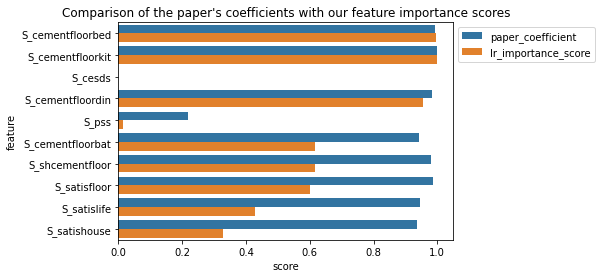

In [43]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Comparison of the paper's coefficients with our feature importance scores")
sns.barplot(x='score', y='feature', hue='variable', data=paper_and_lr_importances_df2plot, orient='h', ax=ax)
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(FIGURES_PATH, 'paper_coefs_vs_lr_importance_scores.png'), bbox_inches='tight')

**Observations:**
- The scores are almost the same for 3 of the cement related features (`S_cementfloorbed`, `S_cementfloorkit`, `S_cementfloordin`) and for `S_cesds`, the depression score.
- `S_cementfloorbat`, `S_shcementfloor`, `S_satisfloor` have similar values in terms of the paper coefficients, and also in terms of the feature importance scores. But they all are considered relatively less important by the feature importance scores compared to the paper coefficients.
- The feature for which the two scores differ the most (on a relative scale) is `S_pss`, which represents the perceived stress of the mother of the households.

We conclude that our feature importance scores agree to some extent quantitatively with the paper coefficients. 
But we advise not to rely too much on them, and rather only use the qualitative information of the ranking, which seems more robust.